In [1]:
# imports

import os 
import math
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt


# methods

'''
Map each letter to a number in the range 0-25 (26 letters in total).
'''
def letter2num(letter):
    return int(ord(letter) - 65)

'''
Add +1 column for the bias. 
'''
def add_bias_input(X):
    bias_array = np.ones(len(X))
    X = np.c_[X,bias_array]
    return X

'''
Shuffle the data.
'''
def shuffle_data(X, y,features):
    data_table = np.c_[X,y]
    np.random.shuffle(data_table)
    return data_table[:,:features], data_table[:,features]

'''
Split the data of a given table (input or output) into training and testing sets considering a fraction.
'''
def train_test_split(table,fraction):
    train_size = len(table) * fraction
    train_size = math.floor(train_size)
    test_size = train_size + 1
    return table[:test_size], table[test_size:]

'''
Create numpy array (either 1d or 2d) and fill it with NaNs.
'''
def create_array(dim1, dim2):
    if dim2 != 0:   # 2d
        arr=np.empty((dim1,dim2))
    else:           # 1d
        arr=np.empty(dim1)
    arr.fill(np.NaN)
    return arr

'''
Sigmoid activation function.
'''
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

'''
Apply the forward pass: find the values of the neurons using the dot product. 
'''
def forward_phase(x_array, row):
    for i in range(numHid1):
        nodesHid1_values[i] = sigmoid(np.dot(x_array[row,:],in2hid_weights[:,i]))
    for i in range(numHid2):
        nodesHid2_values[i] = sigmoid(np.dot(nodesHid1_values[:],hid2hid_weights[:,i]))
    for i in range(numOutput):
        nodesOut_values[i] = sigmoid(np.dot(nodesHid2_values[:],hid2out_weights[:,i]))

'''
Return 1 if the current image is classified correctly.
'''
def calculate_success(target_values):
    if target_values[np.argmax(nodesOut_values)] == 1:
        return 1
    return 0

'''
Return "cost" of the current image to find Mean Square Error in the end of the epoch.
'''
def calculate_error(target_values):
    return sum(np.square(nodesOut_values - target_values))

def make_target_values(row, table):
    arr=np.zeros(26)
    arr[int(table[row])] = 1
    return arr

'''
Update weights using the negative gradient to minimize the error.
'''
def backward_phase(row, target_values):
    global nodesOut_deriv
    nodesOut_deriv = nodesOut_values - target_values
    for i in range(hid2out_weights.shape[0]):
        for j in range(hid2out_weights.shape[1]):
            tmp = hid2out_weights[i][j]
            hid2out_weights[i][j] = hid2out_weights[i][j] - learning_rate * (nodesHid2_values[i] * nodesOut_values[j] * (1-nodesOut_values[j]) * nodesOut_deriv[j]) + momentum * (hid2out_weights[i][j] - hid2out_oldweights[i][j])
            hid2out_oldweights[i][j] = tmp
    
    for z in range(nodesHid2_deriv.shape[0]):
        nodesHid2_deriv[z] = 0
        for w in range(numOutput):
            nodesHid2_deriv[z] = nodesHid2_deriv[z] + (hid2out_weights[z][w] * nodesOut_values[w] * (1-nodesOut_values[w]) * nodesOut_deriv[w])
    for i in range(hid2hid_weights.shape[0]):
        for j in range(hid2hid_weights.shape[1]):
            tmp = hid2hid_weights[i][j]
            hid2hid_weights[i][j] = hid2hid_weights[i][j] - learning_rate * (nodesHid1_values[i] * nodesHid2_values[j] * (1-nodesHid2_values[j]) * nodesHid2_deriv[j]) + momentum * (hid2hid_weights[i][j] - hid2hid_oldweights[i][j])
            hid2hid_oldweights[i][j] = tmp

    for z in range(nodesHid1_deriv.shape[0]):
        nodesHid1_deriv[z] = 0
        for w in range(numHid2):
            nodesHid1_deriv[z] = nodesHid1_deriv[z] + (hid2hid_weights[z][w] * nodesHid2_values[w] * (1-nodesHid2_values[w]) * nodesHid2_deriv[w])
    for i in range(in2hid_weights.shape[0]):
        for j in range(in2hid_weights.shape[1]):
            tmp = in2hid_weights[i][j]
            in2hid_weights[i][j] = in2hid_weights[i][j] - learning_rate * (X_train[row][i] * nodesHid1_values[j] * (1-nodesHid1_values[j]) * nodesHid1_deriv[j]) + momentum * (in2hid_weights[i][j] - in2hid_oldweights[i][j])
            in2hid_oldweights[i][j] = tmp

'''
Vizualize monitored metric.
'''
def vizual(metric, label):
    plt.plot(metric)

    plt.xlabel("EPOCHS")
    plt.ylabel(label)
    plt.title('{} over the EPOCHS'.format(label))
    plt.show()

In [2]:
X = list()
y = list()

# load the data
file = open(os.path.dirname(os.path.abspath("__file__")) + '/datasets/problem2_data.txt')
for line in file.readlines():
    vector = line.split(',')

    y.append(letter2num(vector[0]))
    current_list = list()
    for i in range(1,len(vector)):
        num = int(vector[i].replace('\n', ''))
        num = num / 15.0    # scaling
        current_list.append(num)
    X.append(current_list)
file.close()

# add bias
np.random.seed(10)
X = add_bias_input(X)

# shuffle the data
features = X.shape[1]
X, y = shuffle_data(X, y,features)

# split to train and test sets
fraction = 0.7
X_train, X_test = train_test_split(X,fraction)
y_train, y_test = train_test_split(y,fraction)

In [3]:
# Neural network constants

numInput = features
numHid1 = 10
numHid2 = 10
numOutput = 26 # letters of english alphabet
numLayers = 4

learning_rate = 0.4
epochs = 100
momentum = 0.8

# weights
in2hid_weights = np.random.rand(numInput,numHid1)
hid2hid_weights = np.random.rand(numHid1,numHid2)
hid2out_weights = np.random.rand(numHid1,numOutput)

# old weights
in2hid_oldweights = np.copy(in2hid_weights)
hid2hid_oldweights = np.copy(hid2hid_weights)
hid2out_oldweights = np.copy(hid2out_weights)

# values
nodesHid1_values = create_array(dim1=numHid1,dim2=0)
nodesHid2_values = create_array(dim1=numHid2,dim2=0)
nodesOut_values = create_array(dim1=numOutput,dim2=0)

# derivatives
nodesHid1_deriv = create_array(dim1=numHid1,dim2=0)
nodesHid2_deriv = create_array(dim1=numHid2,dim2=0)
nodesOut_deriv = create_array(dim1=numOutput,dim2=0)

In [4]:
success_list = list()
mse_list = list()

for ep in tqdm(range(epochs)):

    epoch_success = 0
    epoch_mse = 0

    for row in range(X_train.shape[0]):

        # forward phase
        forward_phase(X_train, row)

        # calculate success and error
        target_values = make_target_values(row, y_train)
        epoch_success += calculate_success(target_values)
        epoch_mse += calculate_error(target_values)

        # backward phase
        backward_phase(row, target_values)

    epoch_mse = epoch_mse / X_train.shape[0]

    success_list.append(epoch_success)
    mse_list.append(epoch_mse)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [40:56<00:00, 24.56s/it]


In [18]:
print(success_list)
print('----------------')
print(mse_list)

[527, 549, 1419, 2385, 4004, 5459, 5911, 6276, 6466, 6492, 6941, 6848, 6948, 7002, 7133, 7188, 7393, 7271, 7497, 7425, 7549, 7449, 7709, 7554, 7719, 7373, 7919, 8056, 7900, 8109, 8069, 8136, 7937, 8109, 8057, 8143, 8216, 8252, 8139, 8269, 8194, 8269, 8436, 8262, 8154, 8336, 8139, 8296, 8169, 8250, 8280, 8359, 8301, 8432, 8235, 8210, 8201, 8367, 8309, 8253, 8217, 8338, 8512, 8523, 8503, 8445, 8465, 8430, 7917, 8271, 8481, 8358, 8665, 8677, 8553, 8033, 8485, 8331, 8405, 8454, 8588, 8742, 8564, 8320, 8023, 8627, 8559, 8334, 8572, 8416, 8428, 8385, 8631, 8452, 8614, 8694, 8521, 8739, 8394, 8272]
----------------
[1.006836275865703, 0.9640485089092344, 0.9288599249963299, 0.8797137474685265, 0.8067342200177461, 0.7359745707692266, 0.7150311908464098, 0.6926232146853022, 0.6834722941808954, 0.6694026703005795, 0.6402634607431328, 0.6407278929698313, 0.6388744294628637, 0.6349873403153096, 0.6239158039137754, 0.6222934941039151, 0.6052355129318922, 0.6155195147991711, 0.5932413899010097, 0.60

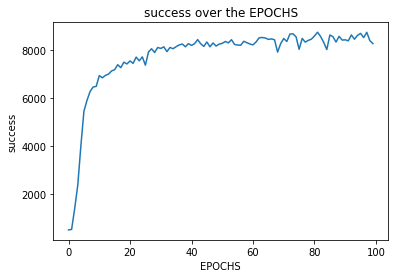

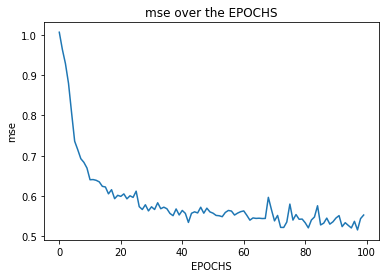

In [5]:
vizual(success_list,'success')
vizual(mse_list,'mse')

In [6]:
test_success = 0
test_mse = 0
for row in range(X_test.shape[0]):

    # forward phase
    forward_phase(X_test, row)

    # calculate success and error
    target_values = make_target_values(row, y_test)
    test_success += calculate_success(target_values)
    test_mse += calculate_error(target_values)

test_mse = test_mse / X_test.shape[0]

print('During testing: ')
print('MSE : ', test_mse)
print('Success: {} (out of {})'.format(test_success,X_test.shape[0]))

During testing: 
MSE :  0.5016831647762331
Success: 3760 (out of 5999)
